In [1]:
import math
import numpy as np
from sympy import *
import matplotlib.pyplot as plt
# import pandas as pd
# import scipy.stats as stats
# import matplotlib as mpl
# from matplotlib import cm
# from matplotlib import rc as matplotlibrc
# from mpl_toolkits.mplot3d import Axes3D
# from matplotlib.ticker import  MultipleLocator
# matplotlibrc('text',   usetex=True)
# matplotlibrc('font',family='serif')

In [2]:
# Known constants
gamma = 1.4
gm1 = gamma - 1
gp1 = gamma + 1
R = 287 # J/(kg*K)

# Given variables
T1 = 300 # K
T4 = 300 # K
P1 = 100 # kPa
P4 = P1 * 5 # P4/P1 = 5

In [3]:
a1 = np.sqrt(gamma * R * T1)
a4 = np.sqrt(gamma * R * T4)

P2_P1 = 2.12787 # from WolframAlpha
P2 = P1 * P2_P1

numerator = gp1/gm1 + P2_P1
denominator = 1 + gp1*P2_P1/gm1
T2 = T1 * P2_P1 * numerator/denominator # K

P3_P4 = P2_P1/(P4/P1) # P3/P4 = P2/P4
P3 = P4 * P3_P4 # kPa

T3 = T4 * P3_P4**(gm1/gamma) # K

W = a1*np.sqrt(gp1/2/gamma*(P2_P1 - 1) + 1) # m/s
up = a1/gamma * (P2_P1 - 1) * np.sqrt(2*gamma/(P2_P1*gp1 + gm1)) # m/s
U1 = 0
u2 = up

a3 = np.sqrt(gamma * R * T3) # m/s

rho1 = P1/(R*T1)
rho2 = rho1 * ((1 + gp1*P2/(gm1*P1))/(gp1/gm1 + P2/P1))
rho4 = P4/(R*T4)
rho3 = (P3/P4)**(1/gamma) * rho4

u1 = 0
u3 = u2
u4 = 0

In [4]:
def all_values(t, diaphragm):
    points = 500
    
    x_arr = np.zeros((points,))
    P_before = np.zeros((points,))
    P_arr = np.zeros((points,))
    rho_arr = np.zeros((points,))
    T_arr = np.zeros((points,))
    u_arr = np.zeros((points,))
    
    xhd = diaphragm - a1 * t # head of rarefaction
    xft = diaphragm + (up - a3) * t # foot of rarefaction
    xcd = diaphragm + up * t # contact discontinuity
    xsh = diaphragm + W * t # shock wave
    
    for i in range(points):
        x_arr[i] = i
        
        # Pressure at t=0s
        if i < diaphragm:
            P_before[i] = P4
        else:
            P_before[i] = P1
        
        # Pressure
        if i < xhd:
            P_arr[i] = P4
        elif i < xft:
            u = 2 / gp1 * (a4 + (x_arr[i] - diaphragm) / t)
            fact = 1 - 0.5 * gm1 * u / a4
            P_arr[i] = P4 * fact ** (2 * gamma / gm1)
        elif i < xcd:
            P_arr[i] = P3
        elif i < xsh:
            P_arr[i] = P2
        else:
            P_arr[i] = P1
        
        # Density
        if i < xhd:
            rho_arr[i] = rho4
        elif i < xft:
            rho_arr[i] = rho4 * (P_arr[i]/P4)**(1/gamma)
        elif i < xcd:
            rho_arr[i] = rho3
        elif i < xsh:
            rho_arr[i] = rho2
        else:
            rho_arr[i] = rho1
        
        # Temperature
        if i < xhd:
            T_arr[i] = T4
        elif i < xft:
            T_arr[i] = P_arr[i]/(R*rho_arr[i])
        elif i < xcd:
            T_arr[i] = T3
        elif i < xsh:
            T_arr[i] = T2
        else:
            T_arr[i] = T1
        
        # Velocity
        if i < xhd:
            u_arr[i] = u4
        elif i < xft:
            u_arr[i] = 2/gp1 * (a4 + (x_arr[i] - diaphragm)/t)
        elif i < xcd:
            u_arr[i] = u3
        elif i < xsh:
            u_arr[i] = u2
        else:
            u_arr[i] = u1

    return x_arr, P_arr, rho_arr, T_arr, u_arr

In [5]:
def Cd_Loth(Re, ug, up, Tg, Tp, D, rhog): # Reynolds num, gas vel, particle vel, gas temp, particle temp, diameter, gas density
    gamma = 1.4
    Ma = abs(ug - up)/np.sqrt(gamma * R * Tg) # Mach number
    if Re == 0:
        return 0
    
    if Re > 45:
        if Ma > 1.5:
            CM = 2.18 - 0.13*math.tanh(0.9*Ma - 2.7)
        else:
            CM = 1.65 + 0.65*math.tanh(4*Ma - 3.4)
        
        if Ma > 0.8:
            GM = 5 + 40/(Ma**3)
        else:
            GM = 166*Ma**3 + 3.29*Ma**2 - 10.9*Ma + 20
        
        if Ma > 1:
            HM = 0.93 + 1/(3.5 + Ma**5)
        else:
            HM = 0.0239*Ma**3 + 0.212*Ma**2 - 0.074*Ma + 1
    
        return 24*(1 + 0.15*Re**0.687)*HM/Re + (0.42*CM)/(1 + 42500*GM*Re**(-1.16))

    if Ma == 0: # speed ratio
        s = 1
    else:
        s = Ma*np.sqrt(gamma/2)
        
    mg = 4.65e-26 # kg, atomic mass of gas
    dg = 4.16e-10 # m, molecule diameter
    lamb = 1/np.sqrt(2) * 1/(np.pi*dg**2) * mg/rhog
    Kn = lamb/D

    C_apdfm = (1 + 2*s**2)*math.exp(-s**2)/(np.sqrt(np.pi)*s**3) + (4*s**4 + 4*s**2 - 1)*math.erf(s)/(2*s**4)
    C_dfm = C_apdfm + 2*np.sqrt(np.pi*Tp/Tg)/(3*s)
    C_dfmRe = C_dfm/(1 + np.sqrt(Re/45)*(C_apdfm/1.63 - 1))
    
    f_Kn = 1/(1 + Kn*(2.514 + 0.8*math.exp(-0.55/Kn)))
    
    C_dKnRe = 24/Re * (1 + 0.15*Re**0.687)*f_Kn
        
    return (C_dKnRe + Ma**4*C_dfmRe)/(1 + Ma**4)

In [6]:
def Cd_Sternin(Re): # Reynolds number
    if Re == 0: 
        return 0.42
    else:
        return 24/Re + 4.4/np.sqrt(Re) + 0.42

In [7]:
def single_particle(x0, u0, D, rho, t0, tf, steps, temp0, diaphragm):
    M = 1/6 * np.pi * D**3 * rho # particle mass = volume * density
    A = np.pi/4 * D**2 # projected area
    mu = 2e-5 # kg/ms, dynamic viscosity
    Pr = 0.72 # Prandtl number
    k_g = 0.025 # W/m*K, thermal conductivity of air
    c_p = 860 # J/(kg*K), specific heat capacity
    tau_v = (rho*D**2)/(18*mu) # velocity response time
    
    dt = (tf - t0)/(steps - 1) # time step
    
    Fd_arr = np.zeros((steps,))
    t_arr = np.zeros((steps,))
    up_arr = np.zeros((steps,))
    up_arr_stokes = np.zeros((steps,))
    xp_arr = np.zeros((steps,))
    Tp_arr = np.zeros((steps,))
    Cd_arr = np.zeros((steps,))
    
    up_arr[0] = u0
    xp_arr[0] = x0
    Tp_arr[0] = temp0
    
    for i in range(steps):
        t_arr[i] = t0 + i * dt
        
        x_arr, P_arr, rho_arr, T_arr, u_arr = all_values(t0 + i * dt, diaphragm)
        
        Re = rho_arr[int(xp_arr[i])] * abs(u_arr[int(xp_arr[i])] - int(up_arr[i])) * D / mu # Reynolds number
        Nu = 0.459 * Pr**0.33 * Re**0.55 # Nusselt number
        Q_qs = np.pi * D * k_g * (T_arr[int(xp_arr[i])] - int(Tp_arr[i])) * Nu # quasi steady state heat convection
        
        # drag coefficient
        Cd = Cd_Loth(Re, int(u_arr[i]), int(up_arr[i]), int(T_arr[i]), int(Tp_arr[i]), D, rho_arr[int(xp_arr[i])]) # Loth, 2008 (compressible)
        # Cd = Cd_Sternin(Re) # Sternin, 1980 (incompressible)
        
        Fd_arr[i] = Cd * rho_arr[int(xp_arr[i])] * A * (u_arr[int(xp_arr[i])] - int(up_arr[i]))**2 / 2 # drag force
        Cd_arr[i] = Cd
        
        # up_arr_stokes[i] = u_arr[int(xp_arr[i])] * (1 - np.exp(-t_arr[i]/tau_v)) # velocity response time
        
        if i != steps - 1:
            up_arr[i + 1] = up_arr[i] + Fd_arr[i]/M * dt
            xp_arr[i + 1] = xp_arr[i] + up_arr[i] * dt
            Tp_arr[i + 1] = Tp_arr[i] + Q_qs/(M * c_p) * dt
        
    return t_arr, up_arr, xp_arr, Fd_arr, Tp_arr, Cd_arr, up_arr_stokes

# Change Particle Diameter and Parametrics

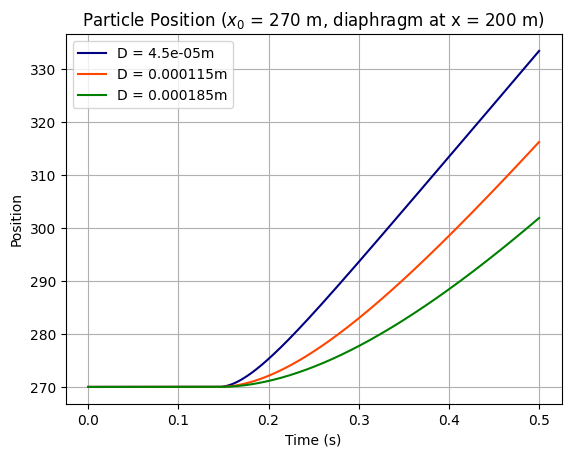

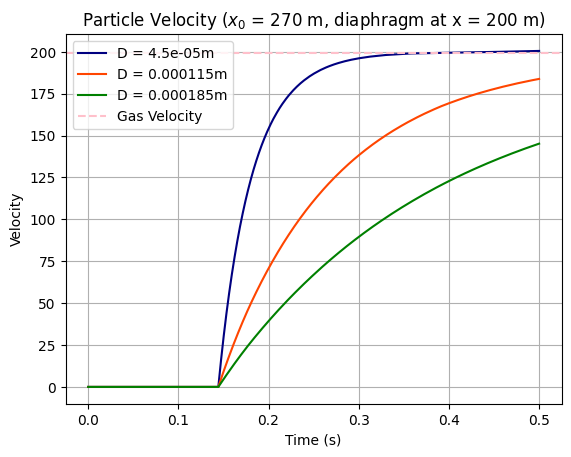

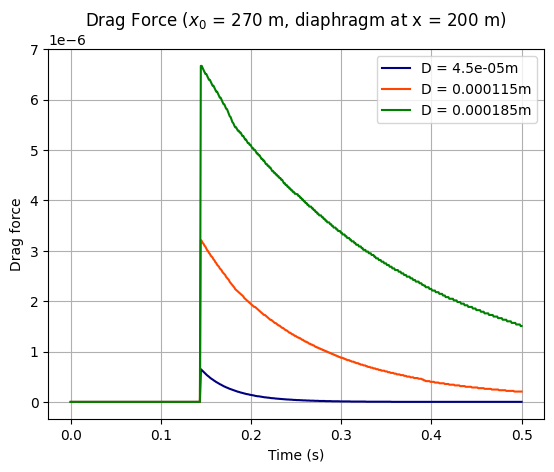

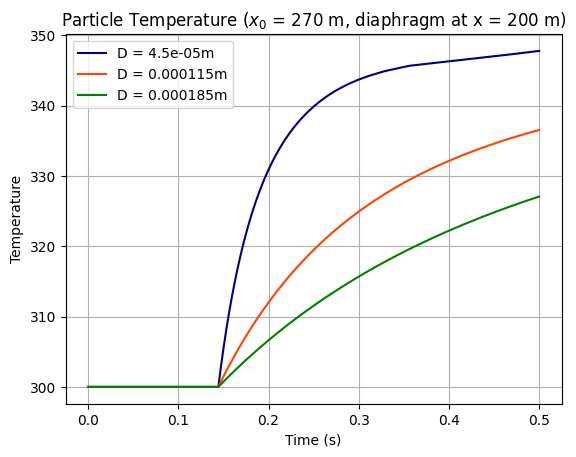

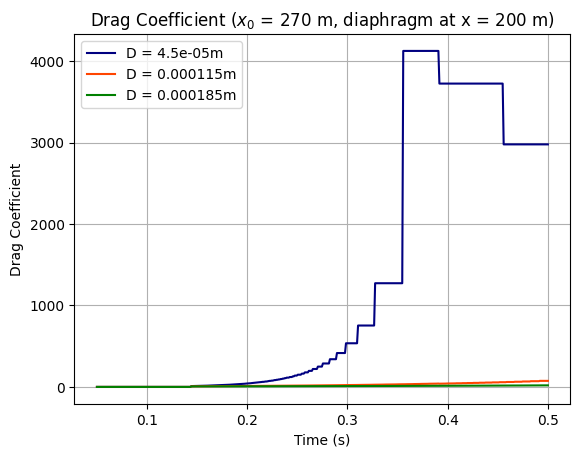

In [8]:
x_p0 = 270 #m, initial particle location
u_p0 = 0 # initial particle velocity
rho_p = 2500 # kg/m^3, particle density

dp_1 = 45e-6 # m, particle diameter
dp_2 = 115e-6
dp_3 = 185e-6
# 115e-6

temp_0 = T1 # 300 K, initial particle temperature

t_0 = 0 # s, initial time
t_f = 0.5 # s, final time

# number of steps
steps = 500

diaphragm = 200 # x value of diaphragm

t_arr, up_arr, xp_arr, Fd_arr, Tp_arr, Cd_arr, up_arr_stokes = single_particle(x_p0, u_p0, dp_1, rho_p, t_0, t_f, steps, temp_0, diaphragm)
t_arr_2, up_arr_2, xp_arr_2, Fd_arr_2, Tp_arr_2, Cd_arr_2, up_arr_stokes_2 = single_particle(x_p0, u_p0, dp_2, rho_p, t_0, t_f, steps, temp_0, diaphragm)
t_arr_3, up_arr_3, xp_arr_3, Fd_arr_3, Tp_arr_3, Cd_arr_3, up_arr_stokes_3 = single_particle(x_p0, u_p0, dp_3, rho_p, t_0, t_f, steps, temp_0, diaphragm)

plt.plot(t_arr, xp_arr, color='navy', label=f'D = {dp_1}m')
plt.plot(t_arr_2, xp_arr_2, color='orangered', label=f'D = {dp_2}m')
plt.plot(t_arr_3, xp_arr_3, color='g', label=f'D = {dp_3}m')
plt.legend(loc=2)
plt.ylabel('Position')
plt.xlabel('Time (s)')
plt.title(f'Particle Position ($x_0$ = {x_p0} m, diaphragm at x = {diaphragm} m)')
plt.grid()
plt.show()

plt.plot(t_arr, up_arr, color='navy', label=f'D = {dp_1}m')
plt.plot(t_arr_2, up_arr_2, color='orangered', label=f'D = {dp_2}m')
plt.plot(t_arr_3, up_arr_3, color='g', label=f'D = {dp_3}m')
plt.axhline(y = u3, color='pink', linestyle = '--', label='Gas Velocity')
plt.legend(loc=2)
plt.ylabel('Velocity')
plt.xlabel('Time (s)')
plt.title(f'Particle Velocity ($x_0$ = {x_p0} m, diaphragm at x = {diaphragm} m)')
plt.grid()
plt.show()

plt.plot(t_arr, Fd_arr, color='navy', label=f'D = {dp_1}m')
plt.plot(t_arr_2, Fd_arr_2, color='orangered', label=f'D = {dp_2}m')
plt.plot(t_arr_3, Fd_arr_3, color='g', label=f'D = {dp_3}m')
plt.legend(loc=1)
plt.ylabel('Drag force')
plt.xlabel('Time (s)')
plt.title(f'Drag Force ($x_0$ = {x_p0} m, diaphragm at x = {diaphragm} m)')
plt.grid()
plt.show()

plt.plot(t_arr, Tp_arr, color='navy', label=f'D = {dp_1}m')
plt.plot(t_arr_2, Tp_arr_2, color='orangered', label=f'D = {dp_2}m')
plt.plot(t_arr_3, Tp_arr_3, color='g', label=f'D = {dp_3}m')
# plt.axhline(y = T2, color='pink', linestyle = '--', label='Gas Temperature')
plt.legend(loc=2)
plt.ylabel('Temperature')
plt.xlabel('Time (s)')
plt.title(f'Particle Temperature ($x_0$ = {x_p0} m, diaphragm at x = {diaphragm} m)')
plt.grid()
plt.show()

end_percent = 90
end_1 = int(-steps*end_percent/100)
end_2 = int(-steps*end_percent/100)
end_3 = int(-steps*end_percent/100)

plt.plot(t_arr[end_1:], Cd_arr[end_1:], color='navy', label=f'D = {dp_1}m')
plt.plot(t_arr_2[end_2:], Cd_arr_2[end_2:], color='orangered', label=f'D = {dp_2}m')
plt.plot(t_arr_3[end_3:], Cd_arr_3[end_3:], color='g', label=f'D = {dp_3}m')
plt.legend(loc=2)
plt.ylabel('Drag Coefficient')
plt.xlabel('Time (s)')
plt.title(f'Drag Coefficient ($x_0$ = {x_p0} m, diaphragm at x = {diaphragm} m)')
plt.grid()
plt.show()

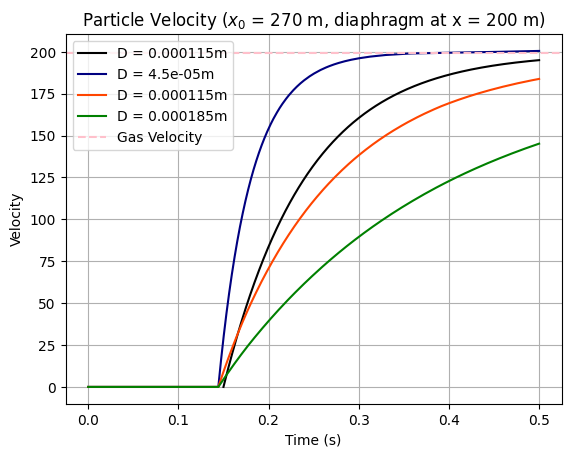

In [9]:
time = np.linspace(0, t_f-0.15, 500)
tau_v = (rho_p*dp_2**2)/(18*(2e-5))

u_p = u3*(1-np.exp(-1*time/tau_v))

tau_f = dp_2/u3
St = tau_v/tau_f
t_star = time/St
# u_p_2 = u3*(1-np.exp(-1*St*t_star))

plt.plot(time+.15, u_p, color='k', label=f'D = {dp_2}m')

# plt.plot(time+.15, u_p_2, color='k', label=f'D = {dp_2}m')

plt.plot(t_arr, up_arr, color='navy', label=f'D = {dp_1}m')
plt.plot(t_arr_2, up_arr_2, color='orangered', label=f'D = {dp_2}m')
plt.plot(t_arr_3, up_arr_3, color='g', label=f'D = {dp_3}m')
plt.axhline(y = u3, color='pink', linestyle = '--', label='Gas Velocity')
plt.legend(loc=2)
plt.ylabel('Velocity')
plt.xlabel('Time (s)')
plt.title(f'Particle Velocity ($x_0$ = {x_p0} m, diaphragm at x = {diaphragm} m)')
plt.grid()